<a href="https://colab.research.google.com/github/GlowingHorse/class-discriminative-vis/blob/master/Comparison_with_%22Building_Blocks_of_Interpretability%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neuron Groups -- Building Blocks of Interpretability

This colab notebook is the method proposed by the paper [**Building Blocks of Intepretability**](https://distill.pub/2018/building-blocks) series exploring how intepretability techniques combine together to explain neural networks.

**Now**, we would like to use the visualization method in this paper for comparison. You can see some region attributing positively will be misunderstood.

**Note that**, in the last output block, you can find the region of the dog head attributing negatively to both dog and cat. Without detecting class-discriminative features before visualizing, the results will be distracted by some uncorrealted classes.

Because this code is written two years ago, you may use Python2 to run it.

<br>

<img src="https://storage.googleapis.com/ancient-wave-209401-vcm/dog_cat224.jpg" width="224"></img>

<br>


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [0]:
!pip install --quiet lucid==0.0.5
!npm install -g svelte-cli@2.2.0
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map

/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
updated 2 packages in 0.411s


# Attribution & UI Code

In [0]:
model = models.InceptionV1()
model.load_graphdef()

W0127 01:51:46.757045 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/reading.py:119: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0127 01:51:46.831567 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/util.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [0]:
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")
labels = [line[line.find(" "):].strip() for line in labels_str.decode().split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [0]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_0Kmqz_/GroupWidget_2dcf416.html > /tmp/svelte_0Kmqz_/GroupWidget_2dcf416.js
svelte version 1.64.1
compiling ../tmp/svelte_0Kmqz_/GroupWidget_2dcf416.html...
(4:4) – A11y: <img> element should have an alt attribute
(6:4) – A11y: <img> element should have an alt attribute
(14:4) – A11y: <img> element should have an alt attribute
(27:6) – A11y: <img> element should have an alt attribute



In [0]:
def raw_class_group_attr(img, layer, label, group_vecs, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    score = T("softmax2_pre_activation")[0, labels.index(label)]
    t_grad = tf.gradients([score], [T(layer)])[0]   
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return [np.sum(group_vec * grad) for group_vec in group_vecs]

In [0]:
def neuron_groups(img, layer, n_groups=6, attr_classes=[]):

  # Compute activations

  with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval()

  # We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
  # to apply Non-Negative Matrix factorization (NMF).

  nmf = ChannelReducer(n_groups, "NMF")
  spatial_factors = nmf.fit_transform(acts)[0].transpose(2, 0, 1).astype("float32")
  channel_factors = nmf._reducer.components_.astype("float32")

  # Let's organize the channels based on their horizontal position in the image

  x_peak = np.argmax(spatial_factors.max(1), 1)
  ns_sorted = np.argsort(x_peak)
  spatial_factors = spatial_factors[ns_sorted]
  channel_factors = channel_factors[ns_sorted]

  # And create a feature visualziation of each group

  param_f = lambda: param.image(80, batch=n_groups)
  obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
            for i in range(n_groups))
  group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]
  
  # We'd also like to know about attribution
  
  # First, let's turn each group into a vector over activations
  group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
                for i in range(n_groups)]
  
  attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
                     for attr_class in attr_classes])
  
  print attrs
  
  # Let's render the visualization!
  
  lucid_svelte.GroupWidget({
    "img" : _image_url(img),
    "n_groups": n_groups,
    "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
    "group_icons": [_image_url(icon) for icon in group_icons] 
  })
  
  

W0127 01:51:47.339140 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/vision_base.py:56: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0127 01:51:50.674808 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.

W0127 01:51:50.766449 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:221: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0127 01:51:50.780672 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/transform.py:37: The name tf.random_crop is deprecated. Please use tf.image.random_crop instead.

W0127 01:51:50.795461 140622735865728 module_wrapper.py:139] From /usr/local/lib/python2.7/d

[[ 0.60318893  1.084592    1.0896422  -0.77748084 -1.9933484   2.7352195 ]
 [ 1.1054739   1.0138965  -0.8297789  -2.0678754   0.37683636  1.0302951 ]]



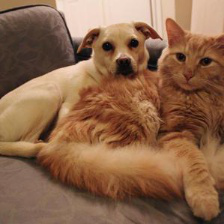
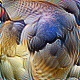
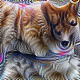
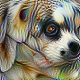
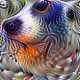
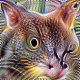
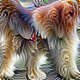

In [0]:
img = load("https://storage.googleapis.com/ancient-wave-209401-vcm/dog_cat224.jpg")
neuron_groups(img, "mixed4d", 6, ["golden retriever", "Egyptian cat"])